In [1]:
%matplotlib inline

import kernel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class GP:
    def __init__(self):
        self.x_train = self.y_train = np.array([])
        self.m = self.Sigma = np.array([])
    
    def kernel(self, x_1, x_2):
        # 好きなカーネルに置き換えてネ
        return kernel.step(x_1, x_2, m=1, sigma_w=sigma_w, sigma_v=sigma_v, sigma_b=sigma_b)
    
    def add_train_data(self, data):
        self.x_train = np.append(self.x_train, data.x)
        self.y_train = np.append(self.y_train, data.y)
        
    def delete_train_data(self):
        self.x_train = self.y_train = np.array([])
    
    def pred(self, x_pred):
        N, M = len(self.x_train), len(x_pred)
        
        K_N = np.empty((N, N))
        for n_1 in range(N):
            for n_2 in range(N):
                K_N[n_1, n_2] = self.kernel(self.x_train[n_1], self.x_train[n_2])        
        K_N += np.eye(N)*sigma_e**2
        K_N_inv = np.linalg.inv(K_N)
        
        k_NM = np.empty((N, M))
        for n in range(N):
            for m in range(M):
                k_NM[n, m] = self.kernel(self.x_train[n], x_pred[m])
        
        K_M = np.empty((M, M))
        for m_1 in range(M):
            for m_2 in range(M):
                K_M[m_1, m_2] = self.kernel(x_pred[m_1], x_pred[m_2])
        K_M += np.eye(M)*sigma_e**2

        self.m = k_NM.T @ K_N_inv @ self.y_train
        self.Sigma  = K_M - k_NM.T @ K_N_inv @ k_NM

In [3]:
class TrainDataset:
    def __init__(self, x_min, x_max, num_data):
        np.random.seed(1)
        self.x = np.sort((x_max-x_min)*np.random.rand(num_data)+x_min)
        self.y = np.array([self.f(self.x[i]) for i in range(num_data)])

    # 背後に存在する真の関数
    def f(self, x):
        if x > 0:
            return 1.0/2.0*x**(1.2) + np.cos(x) + np.random.normal(0, sigma_e)
        else:
            return np.sin(x) + 1.1**x + np.random.normal(0, sigma_e)

1隠れ層NNを次で定式化  
$f(x) = \sum_{j=1}v_jh_j(x)$  
$h_j(x) = \sigma(\sum_{k=1}w_{j, k}x_k + b)$  
ただし、  
$w_{j, k}\sim\mathcal{N}(0, \sigma_w^2)$, 
$v_l\sim\mathcal{N}(0, \sigma_v^2)$, 
$b\sim\mathcal{N}(0, \sigma_b^2)$  

また、観測値$y$は次のように与えられる  
$y = f(x) + \epsilon$  
ただし、  
$\epsilon\sim\mathcal{N}(0, \sigma_\epsilon^2)$

In [4]:
sigma_w, sigma_v, sigma_b = 1.0, 1.0, 1.0
sigma_e = 0.01

In [5]:
x_min, x_max = -7.0, 7.0
y_min, y_max = -5.0, 5.0

事前分布に関して図示

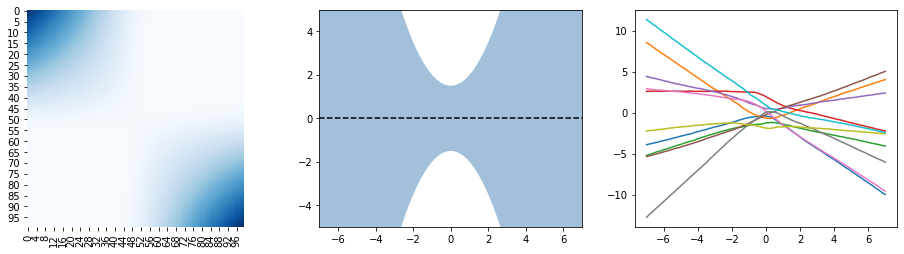

In [6]:
x_pred = np.linspace(x_min, x_max, 100)
gp = GP()

plt.figure(figsize=(16, 4))

# 共分散行列の濃度
plt.subplot(131)

x_pred_1, x_pred_2 = np.meshgrid(x_pred, x_pred)
K = gp.kernel(x_pred_1, x_pred_2)

sns.heatmap(K, cmap="Blues", cbar=False, square=True)

# 事前予測分布
plt.subplot(132)

gp.pred(x_pred)
v = np.diag(gp.Sigma)

upper = np.array([gp.m[i] + v[i] for i in range(len(x_pred))])
lower = np.array([gp.m[i] - v[i] for i in range(len(x_pred))])

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.fill_between(x_pred, upper, lower, facecolor='steelblue',alpha=0.5)
plt.plot(x_pred, gp.m, color='black', linestyle='dashed')

# 事前予測分布からのサンプリング
plt.subplot(133)

for k in range(10):
    sample = np.random.multivariate_normal(gp.m, gp.Sigma)
    plt.plot(x_pred, sample, label=f'Sample {k}')

事後分布に関して図示

In [7]:
num_data = 5
data = TrainDataset(-3, 3, num_data)
gp.delete_train_data()
gp.add_train_data(data)

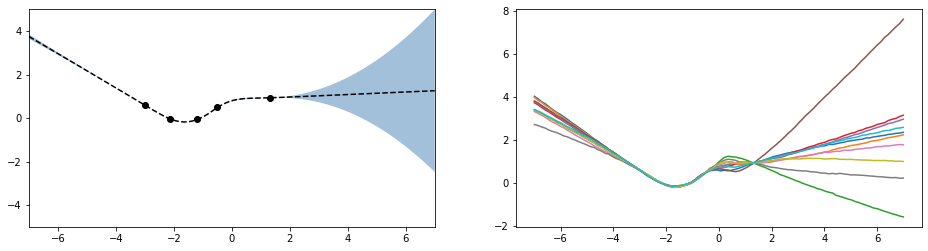

In [8]:
plt.figure(figsize=(16, 4))

# 事後予測分布
plt.subplot(121)

gp.pred(x_pred)
v = np.diag(gp.Sigma)

upper = np.array([gp.m[i] + v[i] for i in range(len(x_pred))])
lower = np.array([gp.m[i] - v[i] for i in range(len(x_pred))])

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.fill_between(x_pred, upper, lower, facecolor='steelblue',alpha=0.5)
plt.plot(x_pred, gp.m, color='black', linestyle='dashed')
plt.scatter(data.x, data.y, color='black')

# 事後分布からのサンプリング
plt.subplot(122)

for k in range(10):
    sample = np.random.multivariate_normal(gp.m, gp.Sigma)
    plt.plot(x_pred, sample, label=f'Sample {k}')